## Task 2

### importing libraries and installing required libraries
##### installing libraries


In [23]:
!pip install requests
!pip install beautifulsoup4
!pip install nltk
!pip install scikit-learn
!pip install matplotlib
!pip install wordcloud

In [24]:
!pip install --upgrade Pillow

##### downloading stopwords

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### importing libraries

In [26]:
import requests
from bs4 import  BeautifulSoup
import csv
import pandas as pd
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

### importing the dataset

The dataset was taken from kaggle website:<br> https://www.kaggle.com/datasets/gpreda/bbc-news?resource=download

In [27]:
df = pd.read_csv('bbc_news.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        29336 non-null  object
 1   pubDate      29336 non-null  object
 2   guid         29336 non-null  object
 3   link         29336 non-null  object
 4   description  29336 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


### Data preprocessing

#### Counting the number of na/null values

In [29]:
nan_count = df.isnull().sum().sum()
print('Number of NaN values:', nan_count)

Number of NaN values: 0


In [30]:
df.tail()

,title,pubDate,guid,link,description
29331,Dutch court orders halt to F-35 jet parts expo...,"Mon, 12 Feb 2024 13:14:40 GMT",https://www.bbc.co.uk/news/world-europe-68272233,https://www.bbc.co.uk/news/world-europe-682722...,Judges sided with groups who said sending spar...
29332,Who are the released hostages?,"Mon, 12 Feb 2024 09:59:47 GMT",https://www.bbc.co.uk/news/world-middle-east-6...,https://www.bbc.co.uk/news/world-middle-east-6...,One-hundred-and-twelve people captured during ...
29333,"What is council tax, how much is it going up b...","Mon, 12 Feb 2024 15:22:42 GMT",https://www.bbc.co.uk/news/uk-politics-55765504,https://www.bbc.co.uk/news/uk-politics-5576550...,Millions of households are expected to see the...
29334,UK interest rates explained,"Thu, 01 Feb 2024 13:36:21 GMT",https://www.bbc.co.uk/news/business-57764601,https://www.bbc.co.uk/news/business-57764601?a...,Bank of England interest rates affect the mort...
29335,Cost of living payments and who gets them,"Mon, 05 Feb 2024 19:51:41 GMT",https://www.bbc.co.uk/news/business-61592496,https://www.bbc.co.uk/news/business-61592496?a...,Millions of low-income households will receive...


#### removing duplicate data

In [31]:
df_unique = df.drop_duplicates()
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29336 entries, 0 to 29335
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        29336 non-null  object
 1   pubDate      29336 non-null  object
 2   guid         29336 non-null  object
 3   link         29336 non-null  object
 4   description  29336 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


#### removing unnecessary columns like pubDate and Links

In [32]:
columns_to_remove = ['pubDate', 'link']
df_filtered = df_unique.drop(columns=columns_to_remove)

In [33]:
df_filtered.head()

,title,guid,description
0,Ukraine: Angry Zelensky vows to punish Russian...,https://www.bbc.co.uk/news/world-europe-60638042,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,https://www.bbc.co.uk/news/world-europe-60641873,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',https://www.bbc.co.uk/news/business-60623941,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,https://www.bbc.co.uk/news/uk-60579079,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,https://www.bbc.co.uk/news/business-60642786,Consumers are feeling the impact of higher ene...


### creating categories from grub

In [34]:
# Create a new column 'categories'
df_filtered['categories'] = None

# Define the conditions and assign categories accordingly
df_filtered.loc[df_filtered['guid'].str.contains('news/world'), 'categories'] = 'Foreign Politics'
df_filtered.loc[df_filtered['guid'].str.contains('sport/'), 'categories'] = 'Sports'
df_filtered.loc[df_filtered['guid'].str.contains('news/uk-england-london'), 'categories'] = 'Current Affairs'

# Drop rows where 'categories' is still None
df_filtered = df_filtered.dropna(subset=['categories'])

# Display the updated DataFrame
print(df_filtered)

                                                   title  \
0      Ukraine: Angry Zelensky vows to punish Russian...   
1      War in Ukraine: Taking cover in a town under a...   
9          Protests across Russia see thousands detained   
10     Ukraine conflict: Your guide to understanding ...   
11     Russian gymnast investigated for wearing pro-w...   
...                                                  ...   
29328  Gaza war: What we know about Israel's Rafah ho...   
29329   Israel says rescued hostages 'in good condition'   
29330                        Why is Rafah the new focus?   
29331  Dutch court orders halt to F-35 jet parts expo...   
29332                     Who are the released hostages?   

                                                    guid  \
0       https://www.bbc.co.uk/news/world-europe-60638042   
1       https://www.bbc.co.uk/news/world-europe-60641873   
9       https://www.bbc.co.uk/news/world-europe-60640204   
10      https://www.bbc.co.uk/news/worl

### Clustering using K-means

In [35]:
# Combine relevant columns into a text feature for clustering
text_feature = df_filtered['title'] + ' ' + df_filtered['title']  # You can customize this based on your features

# Use TfidfVectorizer to convert text data into a numerical format, removing stopwords
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_feature)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters as needed
df_filtered['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print("DataFrame with cluster assignments:")
print(df_filtered)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DataFrame with cluster assignments:
                                                   title  \
0      Ukraine: Angry Zelensky vows to punish Russian...   
1      War in Ukraine: Taking cover in a town under a...   
9          Protests across Russia see thousands detained   
10     Ukraine conflict: Your guide to understanding ...   
11     Russian gymnast investigated for wearing pro-w...   
...                                                  ...   
29328  Gaza war: What we know about Israel's Rafah ho...   
29329   Israel says rescued hostages 'in good condition'   
29330                        Why is Rafah the new focus?   
29331  Dutch court orders halt to F-35 jet parts expo...   
29332                     Who are the released hostages?   

                                                    guid  \
0       https://www.bbc.co.uk/news/world-europe-60638042   
1       https://www.bbc.co.uk/news/world-europe-60641873   
9       https://www.bbc.co.uk/news/world-europe-60640204   
10 

#### The numbers of clusters formed with their count

In [36]:
df_filtered['cluster'].value_counts()

0    11625
1     1212
2     1119
Name: cluster, dtype: int64

In [37]:
for cluster_num in range(df_filtered['cluster'].nunique()):
    cluster_description = df_filtered[df_filtered['cluster'] == cluster_num]['description']

    print(f'\nCluster {cluster_num} Descriptions:')
    print(cluster_description.values)



Cluster 0 Descriptions:
['People have been held in 53 cities, from St Petersburg in the west to Vladivostok in the east.'
 'A Polish couple, messaged from Taiwan, have come to meet a Ukrainian refugee - welcome to Przemysl.'
 'Maxim, a 27-year-old city resident, tells the BBC what happened after the first ceasefire collapsed.'
 ...
 'Israel says it will expand its military operations all the way south into Rafah.'
 'Judges sided with groups who said sending spares from the Netherlands contributed to law violations in Gaza.'
 'One-hundred-and-twelve people captured during the 7 October attacks have been released by Hamas.']

Cluster 1 Descriptions:
['The Ukrainian president says the country will not forgive or forget those who murder its civilians.'
 'Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee.'
 "More than 1.5 million Ukrainians have fled the country. Here's what you need to know after day 11 of the war."
 ...
 'Investigators 

### Generating Wordcloud

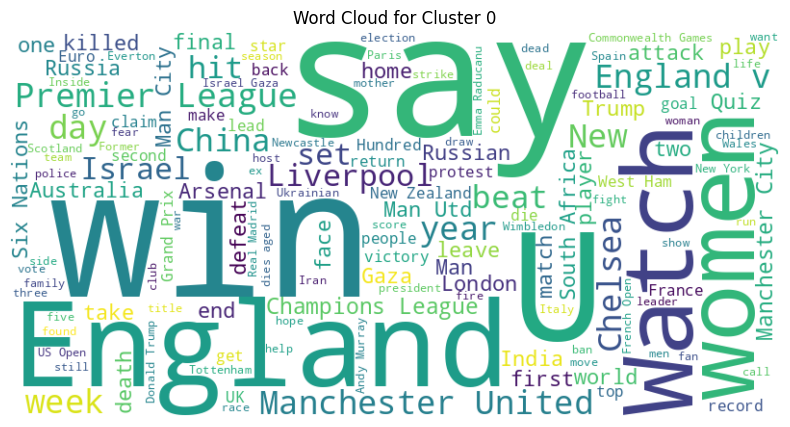

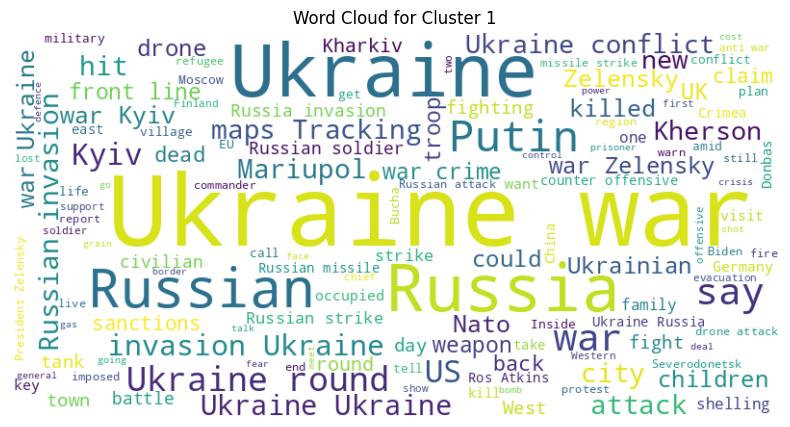

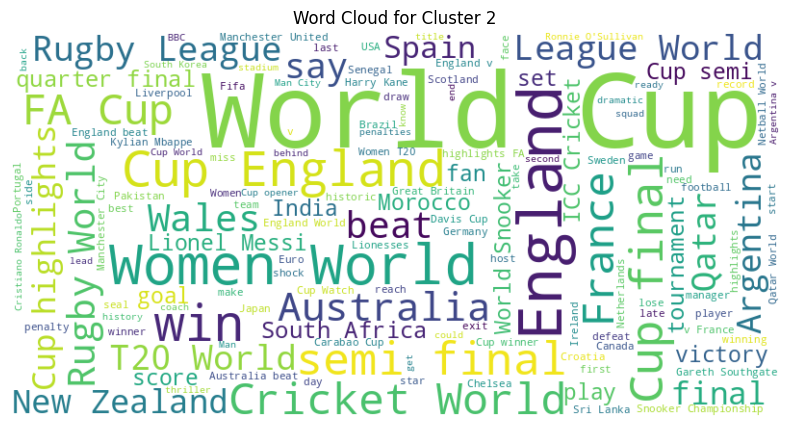

In [38]:
# Generate word clouds for each cluster
for cluster_num in range(df_filtered['cluster'].nunique()):
    cluster_text = ' '.join(text_feature[df_filtered['cluster'] == cluster_num])

    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, min_font_size=10).generate(cluster_text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.axis('off')
    plt.show()


#### Mapping with cluster names

In [39]:
# Create a mapping for cluster names
cluster_names_mapping = {0: 'Current Affairs', 1: 'Foreign Politics', 2: 'Sports'}

# Map cluster numbers to names
df_filtered['cluster_name'] = df_filtered['cluster'].map(cluster_names_mapping)

# Display the DataFrame with cluster names
print("DataFrame with Cluster Names:")
print(df_filtered[['description', 'cluster_name']])


DataFrame with Cluster Names:
                                             description      cluster_name
0      The Ukrainian president says the country will ...  Foreign Politics
1      Jeremy Bowen was on the frontline in Irpin, as...  Foreign Politics
9      People have been held in 53 cities, from St Pe...   Current Affairs
10     More than 1.5 million Ukrainians have fled the...  Foreign Politics
11     Russian gymnast Ivan Kuliak is being investiga...  Foreign Politics
...                                                  ...               ...
29328  Israeli commandos rescued two men in an operat...   Current Affairs
29329  The two men, Israeli-Argentines, were rescued ...   Current Affairs
29330  Israel says it will expand its military operat...   Current Affairs
29331  Judges sided with groups who said sending spar...   Current Affairs
29332  One-hundred-and-twelve people captured during ...   Current Affairs

[13956 rows x 2 columns]


### Evaluation Metrics

In [40]:
from sklearn.metrics import accuracy_score

# Display the DataFrame with cluster names
print("DataFrame with Cluster Names:")
print(df_filtered[['description', 'cluster_name', 'categories']])

# Calculate accuracy
accuracy = accuracy_score(df_filtered['categories'], df_filtered['cluster_name'])

print("Accuracy:", accuracy)

DataFrame with Cluster Names:
                                             description      cluster_name  \
0      The Ukrainian president says the country will ...  Foreign Politics   
1      Jeremy Bowen was on the frontline in Irpin, as...  Foreign Politics   
9      People have been held in 53 cities, from St Pe...   Current Affairs   
10     More than 1.5 million Ukrainians have fled the...  Foreign Politics   
11     Russian gymnast Ivan Kuliak is being investiga...  Foreign Politics   
...                                                  ...               ...   
29328  Israeli commandos rescued two men in an operat...   Current Affairs   
29329  The two men, Israeli-Argentines, were rescued ...   Current Affairs   
29330  Israel says it will expand its military operat...   Current Affairs   
29331  Judges sided with groups who said sending spar...   Current Affairs   
29332  One-hundred-and-twelve people captured during ...   Current Affairs   

             categories  
0      

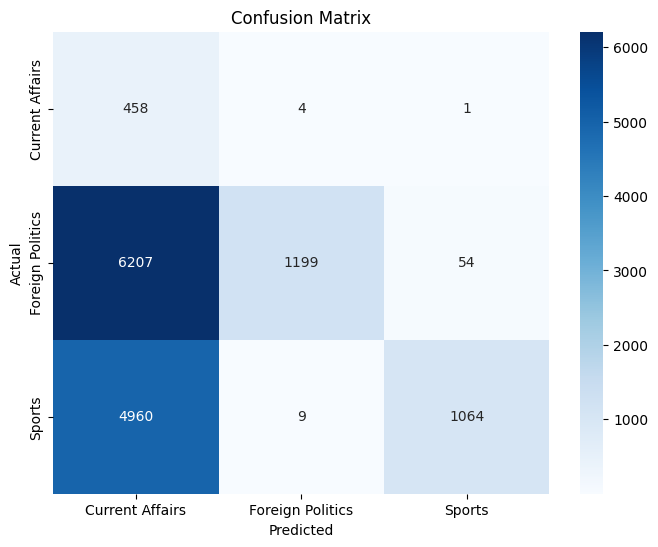

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create confusion matrix
conf_matrix = confusion_matrix(df_filtered['categories'], df_filtered['cluster_name'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cluster_names_mapping.values(), yticklabels=cluster_names_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Testing

In [44]:
given_text = "Super Bowl 2024: Kansas City Chiefs defend NFL title after beating San Francisco 49ers in overtime"

predicted_cluster = kmeans.predict(vectorizer.transform([given_text]))[0]

print(f"The given text belongs to Cluster {predicted_cluster}")

The given text belongs to Cluster 0
